In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import scipy.stats
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from copy import deepcopy
import numpy as np

device = torch.device("cpu")

from IPython import display
from ipywidgets import Output
import time

from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
np.random.seed(42)

n, d = 10000, 100

A = np.random.laplace(0, 10.0, size=(n, d))
x_true = np.random.normal(scale=2.0, size=(d, 1))
y_true = A.dot(x_true)


A = torch.from_numpy(A)
x_true = torch.from_numpy(x_true)
y_true = torch.from_numpy(y_true)

y_true.shape

torch.Size([10000, 1])

In [3]:
def f(A, x, y_true, nu=0.5):
    y_pred = A.mm(x)
    return ((torch.abs(y_pred - y_true) ** (1 + nu)).mean())
#     return ((torch.abs(y_pred - y_true) ** (1 + nu)).mean()) ** (1 / (1 + nu))

mse_loss = torch.nn.MSELoss()
assert torch.isclose(mse_loss(A.mm(x_true + 1), y_true), f(A, x_true + 1, y_true, nu=1.0))

In [4]:
class FromMatricesDataset(Dataset):
    def __init__(self, A, w_true, y_true):
        """
        Args:
            A (n*d numpy array): A - dataset matix
            w_true (d numpy vector): w_true - vector to find
            y_true (n vector): labels
        """
        self.A = torch.from_numpy(A)
        self.w_true = torch.from_numpy(w_true)
        self.y_true = torch.from_numpy(y_true)

    def __len__(self):
        return self.A.shape[0]

    def dim(self):
        return self.A.shape[1]

    def __getitem__(self, idx):
        return (self.A[idx, :], self.y_true[idx])

    def to(self, device):
        self.A = self.A.to(device)
        self.w_true = self.w_true.to(device)
        self.y_true = self.y_true.to(device)
    
    
class LinearModel(object):
    def __init__(self, w):
        self.w = torch.from_numpy(w)
        self.w.requires_grad = True
        return

    def predict(self, A):
        return A.mm(self.w)

    def __call__(self, A):
        return self.predict(A)

    def parameters(self):
        return [self.w]

    def to(self, device):
        self.w = self.w.to(device)


class PNormFunction(object):
    def __init__(self, nu=1.0):
        self.nu = nu
        return
        
    def __call__(self, y_pred, y_true, axis=None):
        return ((torch.abs(y_pred - y_true) ** (1 + self.nu)).mean(axis=axis))


class LevyNoise(object):
    def __init__(self, seed, d, clip_l=-1, alpha=1.0):
        self.rnd = np.random.RandomState(seed)
        self.d = d
        self.clip_level = clip_l
        self.alpha = alpha
        return 
    
    def __call__(self, x):
#         levy_data = scipy.stats.levy.rvs(loc=0, scale=0.5, size=(1 * self.d), random_state=self.rnd)
        levy_data = stats.levy_stable.rvs(alpha=1.5, beta=0.0, size=(1 * self.d), random_state=self.rnd)
        if self.clip_level > 0:
            levy_data = np.clip(levy_data, 0, self.clip_level)[:d, None]
        else:
            levy_data = levy_data[:d, None]
        return self.alpha * x.mm(torch.from_numpy(levy_data)).mean()
#         return torch.abs(x.mm(torch.from_numpy(levy_data))).mean()
#         return levy_data


A = np.random.normal(loc=0, scale=10.0, size=(n, d))
A = scipy.stats.levy.rvs(loc=0, scale=0.5, size=(n, d))
w_true = np.random.normal(scale=2.0, size=(d, 1))
w_pred = np.random.normal(scale=20.0, size=w_true.shape)
y_true = A.dot(w_true)

dataset = FromMatricesDataset(A, w_true, y_true)
model = LinearModel(w_pred + 1)
f = PNormFunction(1.0)

mse_loss = torch.nn.MSELoss()
mse_loss((dataset.A).mm(torch.from_numpy(w_pred) + 1), dataset.y_true)
assert torch.isclose(
    mse_loss((dataset.A).mm(torch.from_numpy(w_pred) + 1), dataset.y_true),
    f(model.predict(dataset.A), dataset.y_true)
)

## Zeroth-order gradient estimation implementation

For zeroth-order gradient estimations we take this usual pipeline
 

    x, y_true = data[0], data[1]
    y_pred = model.predict(x)
    loss = loss_function(y_pred, y_true)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

amd replace backward with custom oracle, that fills .grad of parameters with some zeroth-order gradient estimation (l1/l2)

In [5]:
class Backward(object):
    def __init__(self, params=None):
        raise NotImplementedError("Define backward parameters")

    def __call__(self, model, data, loss_function):
        raise NotImplementedError("Define backward call")
        
class FirstOrderBackward(Backward):
    def __init__(self):
        return

    def __call__(self, model, data, loss_function, loss=None):
        loss.backward()
        return 
        
class ZerothOrderBackwardRandomGradientEstimation(Backward):
    def __init__(self, gamma=0.1, repeats=1):
        self.gamma = gamma
        self.repeats = repeats
        return

    def __call__(self, model, data, loss_function, loss=None):
        loss_function_new = lambda x, y_pred, y_true: loss_function(x, y_pred, y_true) / self.repeats
    
        for _ in range(self.repeats):
            
            self.call_one_repeat(model, data, loss_function_new, loss)
        return

    def call_one_repeat(self, model, data, loss_function, loss=None):
        x, y_true = data[0], data[1]
        y_pred = model.predict(x)
        
        params = model.parameters()
        grads, prev_params = [], []
        for param in params:
            prev_params.append(param.clone())
            grads.append(param.grad.clone())

        params_s, d = self.get_random_direction(params)

        self.do_step_in_direction(params, params_s, self.gamma)
        f1 = loss_function(x, model.predict(x), y_true).item()
        
        self.do_step_in_direction(params, params_s, -2 * self.gamma)
        f2 = loss_function(x, model.predict(x), y_true).item()
        
        with torch.no_grad():
            for param, prev_param, grad, s in zip(params, prev_params, grads, params_s):
                param.copy_(prev_param)
                param.grad.copy_(grad + self.gradient_estimation_step(d, f1, f2, gamma, s))
        return  

    def gradient_estimation_step(self, d, f1, f2, gamma, s):
        raise NotImplementedError("Define gradient_estimation_step call")
    
    def get_random_direction(self, params): 
        raise NotImplementedError("Define get_random_direction call")

    def do_step_in_direction(self, params, params_s, l):
        with torch.no_grad():
            for param, s in zip(params, params_s):
                param.add_(s * l)
        return
        
class ZerothOrderBackwardL2GradientEstimation(ZerothOrderBackwardRandomGradientEstimation):
    def gradient_estimation_step(self, d, f1, f2, gamma, s):
        return d * (f1 - f2) / (2 * self.gamma) * s

    def get_random_direction(self, params): 
        params_s = []
        norm = 0.0
        d = 0.0
        for param in params:
            params_s.append(np.random.normal(0.0, 1.0, size=param.shape))
            norm += (params_s[-1] ** 2).sum()
            d += params_s[-1].size

        norm = norm ** 0.5

        for i, s in enumerate(params_s):
            s /= norm
            params_s[i] = torch.from_numpy(s)

        return params_s, d
        
class ZerothOrderBackwardL1GradientEstimation(ZerothOrderBackwardRandomGradientEstimation):
    def gradient_estimation_step(self, d, f1, f2, gamma, s):
        return d * (f1 - f2) / (2 * self.gamma) * torch.sign(s)

    def get_random_direction(self, params): 
        params_s = []
        norm = 0.0
        d = 0.0
        for param in params:
            params_s.append(np.random.laplace(0.0, 1.0, size=param.shape))
            norm += np.abs(params_s[-1]).sum()
            d += params_s[-1].size

        for i, s in enumerate(params_s):
            s /= norm
            params_s[i] = torch.from_numpy(s)

        return params_s, d

## Test zero-order gradient approximation quality
We use dummy task of form

$$Aw_{true} = y_{true}, f(w_{pred})=||Aw_{pred} - y_{true}||_p$$ 

and look at

$$\frac{\left\Vert\frac{1}{n}\sum\limits_{i=1}^n\tilde\nabla f(w_{pred}, u_i) - \nabla f(w_{pred})\right\Vert}{\left\Vert\nabla f(w_{pred})\right\Vert}$$

where $\tilde\nabla f(w_{pred}, u_i)$ is a zeroth-order gradient estimation (l1/l2)

In [6]:
np.random.seed(42)

n, d = 10, 2

A = np.random.normal(loc=0, scale=0.5, size=(n, d))
w_true = np.random.normal(scale=2.0, size=(d, 1))
w_pred = np.random.normal(scale=2.0, size=w_true.shape)

y_true = A.dot(w_true)

dataset = FromMatricesDataset(A, w_true, y_true)
model = LinearModel(w_pred)
f = PNormFunction(1.0)

In [7]:
# just for zero_grad()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [8]:
predict = model.predict(dataset.A)
loss = f(predict, dataset.y_true)
loss.backward()

param = model.parameters()[0]
real_grad = param.grad.clone()
optimizer.zero_grad()

In [9]:
print("real gradient: \n", real_grad)

real gradient: 
 tensor([[-1.6268],
        [-1.6524]], dtype=torch.float64)


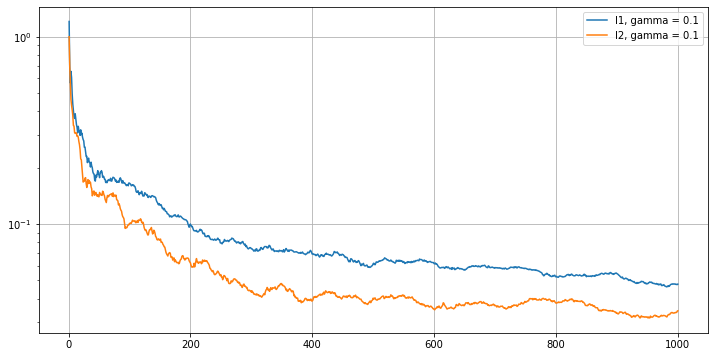

In [10]:
np.random.seed(42)

iters = 1000
mean_repeats = 10
x = np.arange(1, iters + 1)
losses_lines = []

gammas = [1.0, 0.1, 0.01, 0.001, 0.0001]
gammas = [0.1]
backward_funcs = [x for x in zip(["l1", "l2"], [
        ZerothOrderBackwardL1GradientEstimation,
        ZerothOrderBackwardL2GradientEstimation
    ])
]

out = Output()
display.display(out)

labels = []
for gamma in gammas:
    for backward_type, backward in backward_funcs:
        labels.append("{}, gamma = {}".format(backward_type, gamma))

for gamma in gammas:
    for backward_type, backward in backward_funcs:
        losses_global = np.zeros(iters)
        for _ in range(mean_repeats):
            backward_func = backward(gamma=gamma, repeats=1)
            losses = []
            for i in x:
                backward_func(model, [dataset.A, dataset.y_true], 
                              lambda x,y_pred,y_true: (f(y_pred,y_true) + 0)
                )
                losses.append(torch.norm(param.grad / i - real_grad).item() / torch.norm(real_grad).item())
            optimizer.zero_grad()
            losses_global += np.array(losses)
        losses_lines.append(losses_global / mean_repeats)

        display.clear_output(wait=True)
        
        plt.figure(figsize=(12, 6))
        for losses, label in zip(losses_lines, labels):
            plt.plot(x, losses, label=label)
        plt.title("")
        plt.legend()
        plt.yscale("log")
        plt.grid(True)
        plt.show()

So, it works. Let's illustrate path of one of them

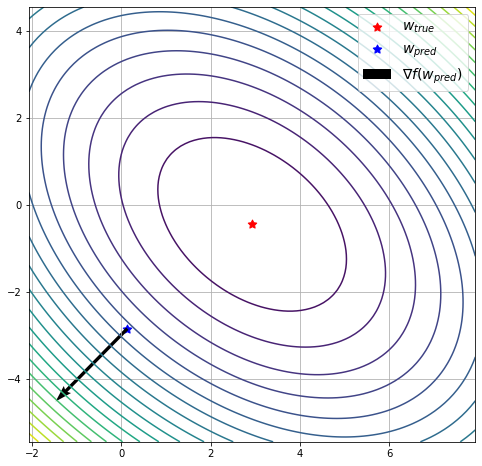

In [11]:
resolution = 101
point_lim = 5
x1_for_contour = np.linspace(-point_lim+w_true[0], point_lim+w_true[0], resolution)
x2_for_contour = np.linspace(-point_lim+w_true[1], point_lim+w_true[1], resolution)
points_for_contour = torch.Tensor(np.stack(np.meshgrid(x1_for_contour, x2_for_contour), axis=2))

plt.figure(figsize=(8, 8))
plt.contour(
    points_for_contour[:,:,0], 
    points_for_contour[:,:,1],
    f(points_for_contour.matmul(dataset.A.T.float()).permute(2,0,1), dataset.y_true[:, 0][:, None, None], axis=0),
    levels=20
)

plt.scatter(w_true[0], w_true[1], s=80, c="red", marker=(5, 1), label=r"$w_{true}$")
plt.scatter(w_pred[0], w_pred[1], s=80, c="blue", marker=(5, 1), label=r"$w_{pred}$")
plt.quiver(
    w_pred[0], w_pred[1], real_grad[0].item(), real_grad[1].item(), 
    label=r"$\nabla f(w_{pred})$", units="xy", scale=1.0)
plt.legend(fontsize=14)
plt.grid(True)
plt.show()

Output()

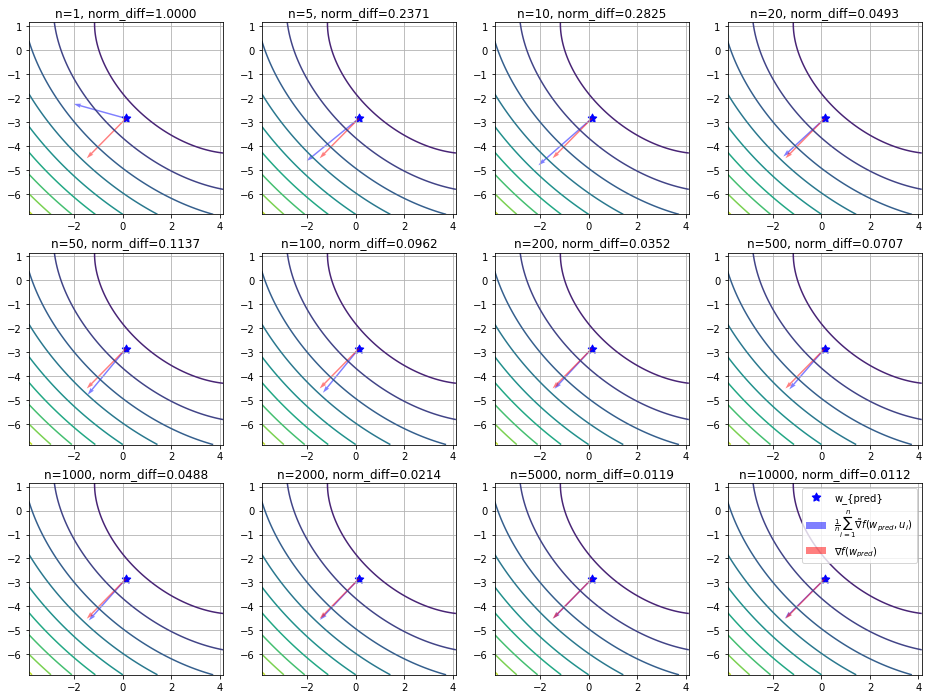

In [12]:
np.random.seed(42)

iters = 10000
x = np.arange(1, iters + 1)

fig = plt.figure(figsize=(16,12))
gs = plt.GridSpec(3,4, figure=fig)

resolution = 101
point_lim = 4
x1_for_contour = np.linspace(-point_lim+w_pred[0], point_lim+w_pred[0], resolution)
x2_for_contour = np.linspace(-point_lim+w_pred[1], point_lim+w_pred[1], resolution)
points_for_contour = torch.Tensor(np.stack(np.meshgrid(x1_for_contour, x2_for_contour), axis=2))

func_levels = f(points_for_contour.matmul(dataset.A.T.float()).permute(2,0,1), dataset.y_true[:, 0][:, None, None], axis=0)

gamma = 0.01
backward_func = ZerothOrderBackwardL2GradientEstimation(gamma=gamma)

out = Output()
display.display(out)

steps = [1, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
gradient_estimations = []
losses = []

optimizer.zero_grad()

for i in x:
    backward_func(model, [dataset.A, dataset.y_true], 
                  lambda x,y_pred,y_true: (f(y_pred,y_true) + 0)
    )
    if i in set(steps):
        gradient_estimations.append((param.grad / i).numpy())
        losses.append(torch.norm(param.grad / i - real_grad).item() / torch.norm(real_grad).item())

optimizer.zero_grad()

for i_y in range(3):
    for i_x in range(4):
        i = i_y * 4 + i_x
        ax = fig.add_subplot(gs[i_y:i_y+1,i_x:i_x+1])
        
        estimated_grad = gradient_estimations[i]
        ax.contour(
            points_for_contour[:,:,0], 
            points_for_contour[:,:,1],
            func_levels,
            levels=10
        )

        ax.scatter(w_pred[0], w_pred[1], s=80, c="blue", marker=(5, 1), label="w_{pred}")
        ax.quiver(
            w_pred[0], w_pred[1], estimated_grad[0].item(), estimated_grad[1].item(), 
            label=r"$\frac{1}{n}\sum_{i=1}^n\tilde\nabla f(w_{pred}, u_i)$", units="xy", scale=1.0,
            alpha=0.5, color="blue"
        )
        ax.quiver(
            w_pred[0], w_pred[1], real_grad[0].item(), real_grad[1].item(), 
            label=r"$\nabla f(w_{pred})$", units="xy", scale=1.0,
            alpha=0.5, color="red"
        )
        ax.set_title("n={}, norm_diff={:0.4f}".format(steps[i], losses[i]))
        ax.grid()
        if i == 11:
            ax.legend()

plt.show()

## Try zeroth-order estimations on synth optimization problems

In [13]:
from graph_plot_tools import smooth, group_uniques
from utils import *
from optimizers import clipped_SGD, clipped_SSTM

from joblib import Parallel, delayed

In [14]:
def smooth(a, eps=0.01, n_start=None):
    if n_start is not None and len(a) >= n_start:
        b = [np.array(a[:n_start]).mean()]
    else:
        b = [a[0]]
    for e in a[1:]:
        b.append(b[-1] * (1 - eps) + e * eps)
    return b


class ProgressParallel(Parallel):
    def __init__(self, *args, **kwargs):
        self._tqdm_total = kwargs.pop('tqdm_total', None)
        self._tqdm_leave = kwargs.pop('tqdm_leave', None)
        self._tqdm_disable = kwargs.pop('tqdm_disable', None)
        super().__init__(*args, **kwargs)

    def __call__(self, *args, **kwargs):
        with tqdm(total=self._tqdm_total, leave=self._tqdm_leave, disable=self._tqdm_disable) as self._pbar:
            return Parallel.__call__(self, *args, **kwargs)

    def print_progress(self):
        if self._tqdm_total is None:
            self._pbar.total = self.n_dispatched_tasks
        self._pbar.n = self.n_completed_tasks
        self._pbar.refresh()

In [15]:
def get_normal_distr_data(n, d, n_train, n_test, data_seed, start_point_seed, noise_level=1.0):
    np.random.seed(data_seed)
    start_point_r = np.random.RandomState(start_point_seed)
    
    base_A = np.random.normal(loc=0, scale=1.0, size=(n, d))

    w_true = np.random.normal(scale=1.0, size=(d, 1))
    w_pred = start_point_r.normal(scale=1.0, size=w_true.shape)
    w_true = w_true / np.linalg.norm(w_true) * 1.
    w_pred = w_pred / np.linalg.norm(w_pred) * 10.

    y_true_base = base_A.dot(w_true)
    y_true_base_with_noise = y_true_base + noise_level * np.random.normal(scale=0.1, size=(n, 1))

    choice = np.random.choice(n, n_train + n_test, replace = False)
    
    A_temp = base_A[choice, :]
    A_train = A_temp[:n_train]
    A_test = A_temp[n_train:]

    y_true_train = y_true_base_with_noise[choice][:n_train]

    y_true_test = y_true_base[choice][n_train:]
    
    name = "normal, n={},d={},n_train={},n_test={},noise_level={}".format(
        n, d, n_train, n_test, noise_level
    )
    return name, A_train, A_test, w_true, w_pred, y_true_train, y_true_test


def get_normal_distr_data_with_levy_noise(
    n, d, n_train, n_test, data_seed, start_point_seed, noise_level=1.0, 
    levy_clip_level=-1, levy_alpha=1.0
):
    name, A_train, A_test, w_true, w_pred, y_true_train, y_true_test = get_normal_distr_data(
        n, d, n_train, n_test, data_seed, start_point_seed, noise_level=noise_level
    )
    
    levy_noise_gen = LevyNoise(start_point_seed, d, levy_clip_level, levy_alpha)
    return name, A_train, A_test, w_true, w_pred, y_true_train, y_true_test, levy_noise_gen


def get_levy_distr_data(n, d, n_train, n_test, dataset_seed, start_point_seed, noise_level=1.0):
    np.random.seed(dataset_seed)
    start_point_r = np.random.RandomState(start_point_seed)
    clip_l = 10000

    levy_data = scipy.stats.levy.rvs(loc=0, scale=0.5, size=(20 * n, 1))
    levy_data = levy_data[levy_data < clip_l][:, None]
    levy_data = levy_data - levy_data.mean()

    A = np.random.normal(loc=0, scale=1.0, size=(n, d)) * levy_data[:n, :]
    base_A = A / A.std(axis=0)

    w_true = np.random.normal(scale=1.0, size=(d, 1))
    w_pred = start_point_r.normal(scale=1.0, size=w_true.shape)
    w_true = w_true / np.linalg.norm(w_true) * 1.
    w_pred = w_pred / np.linalg.norm(w_pred) * 10.

    y_true_base = base_A.dot(w_true)
    y_true_base_with_noise = y_true_base + levy_data[n:2*n] / clip_l * 10

    choice = np.random.choice(n, n_train + n_test, replace = False)
    
    A_temp = base_A[choice, :]
    A_train = A_temp[:n_train]
    A_test = A_temp[n_train:]

    y_true_train = y_true_base_with_noise[choice][:n_train]

    y_true_test = y_true_base[choice][n_train:]
    
    name = "levy, n={},d={},n_train={},n_test={}".format(
        n, d, n_train, n_test
    )
    return name, A_train, A_test, w_true, w_pred, y_true_train, y_true_test

In [16]:
np.random.seed(42)

n, d = 1000, 16
n_train = 500
n_test = 500

levy_clip_level = -1

data_func = get_normal_distr_data_with_levy_noise

batch_sizes = [10, 50, 100, 500]
dataset_seed = 0
start_point_seeds = [x for x in range(0, 1)] # (0, 5) in paper
seeds = [x for x in range(0, 1)] # (0, 3) in paper

p = 1.0
loss_function = PNormFunction(p)

datas = {}
for start_point_seed in start_point_seeds:
    name, A_train, A_test, w_true, w_pred, y_true_train, y_true_test, noise_gen = data_func(
        n, d, n_train, n_test, dataset_seed, start_point_seed, noise_level=0.0, 
        levy_clip_level=levy_clip_level, levy_alpha=1.0
    )
    datas[start_point_seed] = (name, A_train, A_test, w_true, w_pred, y_true_train, y_true_test, noise_gen)

bw_name_to_class = {
    "zo_l1": ZerothOrderBackwardL1GradientEstimation,
    "zo_l2": ZerothOrderBackwardL2GradientEstimation,
    "fo_bw": FirstOrderBackward,
}
        
backwards_params = [
#     {"bw_name": "zo_l1", "bw_params": {"gamma": 0.01}},
    {"bw_name": "zo_l2", "bw_params": {"gamma": 1.0, "repeats": 1}},
#     {"bw_name": "zo_l2", "bw_params": {"gamma": 0.1, "repeats": 1}},
#     {"bw_name": "fo_bw", "bw_params": {}},
]

opt_name_to_class = {
    "adam": torch.optim.Adam,
    "sgd": torch.optim.SGD,
    "clipped_sgd": clipped_SGD,
    "sstm": clipped_SSTM,
    "clipped_sstm": clipped_SSTM,
}

optimizers_params = [
#     # sgd
    {"opt_name": "sgd", "opt_params": {
        "lr": 1e-4, "momentum": 0.9
    }, "outer_params": {"bs_mul": 1, "batch_size": [100]},
    },

    # sstm
    {"opt_name": "sstm", "opt_params": {
        "lr": 1e-5, "L": 1.0, "clipping_type": "no_clip", "clipping_level": 1.0, "nu": 1.0
    }, "outer_params": {"bs_mul": 1, "batch_size": [500]},
    },

#     # clpped_sstm
    {"opt_name": "clipped_sstm", "opt_params": {
        "lr": 1e-3, "L": 1.0, "clipping_type": "norm", "clipping_level": 0.01, "nu": 1.0
    }, "outer_params": {"bs_mul": 1, "batch_size": [10]},
    },
]


def get_task_full_name(opt_params):
    return ", ".join(
        [opt_params["opt_name"] + "__" + opt_params["bw_name"]] + 
        ["{key}: {value}".format(key=key, value=opt_params["opt_params"][key]) for key in opt_params["opt_params"]] +
        ["{key}: {value}".format(key=key, value=opt_params["bw_params"][key]) for key in opt_params["bw_params"]] + 
        ["{key}: {value}".format(key=key, value=opt_params["outer_params"][key]) for key in opt_params["outer_params"]]
    )

def get_task_short_name(opt_params):
    return ", ".join(
        [opt_params["opt_name"] + "__" + opt_params["bw_name"]] + 
        ["{value}".format(value=opt_params["opt_params"][key]) for key in opt_params["opt_params"]] +  
        ["{value}".format(value=opt_params["bw_params"][key]) for key in opt_params["bw_params"]] +  
        ["{value}".format(value=opt_params["outer_params"][key]) for key in opt_params["outer_params"]]
    )

tasks_params = []
for bw_p in backwards_params:
    for opt_p in optimizers_params:
        local_batch_sizes = batch_sizes
        if "batch_size" in opt_p["outer_params"]:
            if isinstance(opt_p["outer_params"]["batch_size"], list):
                local_batch_sizes = opt_p["outer_params"]["batch_size"]
            else:
                local_batch_sizes = [opt_p["outer_params"]["batch_size"]]
        for bs in local_batch_sizes:
            y = deepcopy(bw_p) 
            y.update(deepcopy(opt_p))
            y["outer_params"]["batch_size"] = bs
            y["task_name"] = get_task_full_name(y)
            y["task_short_name"] = get_task_short_name(y)
            tasks_params.append(y)

tasks = []

for start_point_seed in tqdm(start_point_seeds, total=len(start_point_seeds)):
    (dataset_name, A_train, A_test, w_true, w_pred, y_true_train, y_true_test, noise_gen) = datas[start_point_seed]
    training_data = FromMatricesDataset(A_train, w_true.copy(), y_true_train.copy())
    test_data = FromMatricesDataset(A_test, w_true.copy(), y_true_test.copy())
    for task_params in tqdm(tasks_params, total=len(tasks_params), leave=False):
        for seed in seeds:
            torch.manual_seed(seed)

            train_dataloader = DataLoader(training_data, batch_size=task_params["outer_params"]["batch_size"], shuffle=True)
            train_dataloader_for_full_grad = DataLoader(training_data, batch_size=len(test_data), shuffle=False)
            test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=True)

            model = LinearModel(w_pred.copy())
            true_model = LinearModel(w_true.copy())

            optimizer = opt_name_to_class[task_params["opt_name"]](model.parameters(), **task_params["opt_params"])
            backward = bw_name_to_class[task_params["bw_name"]](**task_params["bw_params"])
            
            init_loss, train_loss_in_w_true = None, None
            with torch.no_grad():
                for data in train_dataloader_for_full_grad:
                    x, y_true = data[0], data[1]
                    y_pred = model.predict(x)
                    init_loss = loss_function(y_pred, y_true).detach().cpu().item()
                    del(x, y_true, y_pred)

                    x, y_true = data[0], data[1]
                    y_pred = true_model.predict(x)
                    train_loss_in_w_true = loss_function(y_pred, y_true).detach().cpu().item()
                    del(x, y_true, y_pred)
                    
                
            for data in train_dataloader_for_full_grad:
                x, y_true = data[0], data[1]
                y_pred = model.predict(x)
                loss_function(y_pred, y_true).backward()
                optimizer.zero_grad()
                del(x, y_true, y_pred)
            
            tasks.append({
                "train_dataloader": train_dataloader,
                "train_dataloader_for_full_grad": train_dataloader_for_full_grad,
                "test_dataloader": test_dataloader,
                "model": model,
                "true_model": true_model,
                "optimizer": optimizer,
                "backward": backward,
                "task_params": task_params,
                "init_loss": init_loss,
                "train_loss_in_w_true": train_loss_in_w_true,
                "total_steps": 0,
                "dataset_name": dataset_name,
                "noise_gen": noise_gen
            })
        
print("Number of tasks: {}".format(len(tasks)))


Number of tasks: 3


In [17]:
# # obtain better approximation point
# name, A_train, A_test, w_true, w_pred, y_true_train, y_true_test, noise_gen = data_func(
#     n, d, n_train, n_test, dataset_seed, 0, noise_level=0.0, levy_clip_level=1e-10
# )

# w_pred = w_true

# training_data = FromMatricesDataset(A_train, w_true.copy(), y_true_train.copy())
# test_data = FromMatricesDataset(A_test, w_true.copy(), y_true_test.copy())

# torch.manual_seed(0)

# train_dataloader = DataLoader(training_data, batch_size=n_train, shuffle=True)

# backwards_params = [
#     {"bw_name": "fo_bw", "bw_params": {}},
# ]

# optimizers_params = [
#     # adam
#     {"opt_name": "adam", "opt_params": {
#         "lr": 1e-3, "betas":(0.9, 0.999)
#     }, "outer_params": {"bs_mul": 1, "batch_size": [n_train]}},
# ]

# tasks_params = []
# for bw_p in backwards_params:
#     for opt_p in optimizers_params:
#         local_batch_sizes = batch_sizes
#         if "batch_size" in opt_p["outer_params"]:
#             if isinstance(opt_p["outer_params"]["batch_size"], list):
#                 local_batch_sizes = opt_p["outer_params"]["batch_size"]
#             else:
#                 local_batch_sizes = [opt_p["outer_params"]["batch_size"]]
#         for bs in local_batch_sizes:
#             y = deepcopy(bw_p) 
#             y.update(deepcopy(opt_p))
#             y["outer_params"]["batch_size"] = bs
#             y["task_name"] = get_task_full_name(y)
#             y["task_short_name"] = get_task_short_name(y)
#             tasks_params.append(y)

# task_params = tasks_params[0]

# model = LinearModel(w_pred.copy())
# true_model = LinearModel(w_true.copy())

# optimizer = opt_name_to_class[task_params["opt_name"]](model.parameters(), **task_params["opt_params"])
# backward = bw_name_to_class[task_params["bw_name"]](**task_params["bw_params"])

# epochs_total = 2000

# best_loss = 1e9
# for epoch in tqdm(range(0, epochs_total), total=epochs_total):
#     for data in train_dataloader:
#         x, y_true = data[0], data[1]
#         y_pred = model.predict(x)

#         noise = noise_gen(x)
#         loss = loss_function(y_pred, y_true) + noise

#         backward(model, data, lambda x,y: loss_function(x,y), loss)

#         optimizer.step()
#         optimizer.zero_grad()

#         best_loss = min(best_loss, loss.detach().cpu().item())
#         print(noise, best_loss)

#         del(x, y_true, y_pred, loss)
    
# for task in tasks:
#     task["train_loss_in_w_best"] = best_loss

for task in tasks:
    task["train_loss_in_w_best"] = 0
#     print("{:.6f} {:.6f}".format(task["train_loss_in_w_true"], task["train_loss_in_w_best"]))

In [18]:
def recursive_to(param, device):
    # Not sure if there are any global tensors in the state dict
    if isinstance(param, torch.Tensor):
        param.data = param.data.to(device)
        if param._grad is not None:
            param._grad.data = param._grad.data.to(device)
    elif isinstance(param, dict):
        for subparam in param.values():
            recursive_to(subparam, device)
    elif isinstance(param, list):
        for subparam in param:
            recursive_to(subparam, device)

def optimizer_to(optim, device):
    for param_group in optim.param_groups:
        for param in param_group.values():
            # Not sure there are any global tensors in the state dict
            recursive_to(param, device)
            
def task_to(task, device):
    optimizer_to(task["optimizer"], device)
    task["model"].to(device)
    task["true_model"].to(device)
    task["train_dataloader"].dataset.to(device)
    task["test_dataloader"].dataset.to(device)
    task["train_dataloader_for_full_grad"].dataset.to(device)
    return

def add_to_losses(loss_hist, new_loss):
    loss_hist["ys"].append(new_loss)
    if len(loss_hist["xs"]) == 0:
        loss_hist["xs"].append(0)
    else:
        loss_hist["xs"].append(loss_hist["xs"][-1] + loss_hist["x_step"])
    return 

def add_to_norm_diffs(norm_diffs_hist, norm_diffs, epoch):
    norm_diffs_hist["diffs"].append(norm_diffs)
    if len(norm_diffs_hist["xs"]) == 0:
        norm_diffs_hist["xs"].append(0)
    else:
        norm_diffs_hist["xs"].append(norm_diffs_hist["xs"][-1] + norm_diffs_hist["x_step"])
    norm_diffs_hist["epochs"].append(epoch)
    return 

In [19]:
import scipy
from scipy import stats
from tqdm.notebook import tqdm

def get_batch_grad(model):
    gr=[]
    for i in model.parameters():
        if i.requires_grad:
            gr.append(i.grad.view(-1))
    return torch.cat(gr)


def get_loss(model, criterion, batch):
    x, y_true = batch[0], batch[1]
    y_pred = model.predict(x)
    loss = criterion(y_true, y_pred)
    return loss


def compute_full_grad(model, optimizer, criterion, dataloader_for_full_grad):
    fully_grad = []
    optimizer.zero_grad()

#     print("Computing full gradient")
    with tqdm(total=len(dataloader_for_full_grad), leave=False) as pbar:
        for step, batch in enumerate(dataloader_for_full_grad, start=1):
            loss = get_loss(model, criterion, batch)
            loss.backward()

            if fully_grad != []:
                fully_grad = fully_grad + get_batch_grad(model) * \
                    dataloader_for_full_grad.batch_size
            else:
                fully_grad = get_batch_grad(model) * dataloader_for_full_grad.batch_size
            optimizer.zero_grad()

            pbar.update(1)
    return fully_grad / (step * dataloader_for_full_grad.batch_size)


def compute_norm_diffs(model, optimizer, criterion, dataloader_for_full_grad, dataloader, full_grad=None, 
                       repeats=1, batches=10000):
    if full_grad is None:
        full_grad = compute_full_grad(model, optimizer, criterion, dataloader_for_full_grad)
    mini_norms = []
    optimizer.zero_grad()
#     print("Computing norm diffs")
    repeats = 0
    with tqdm(total=batches, leave=False) as pbar:
        for _ in range((batches + len(dataloader) - 1) // len(dataloader)):
            for step, batch in enumerate(dataloader):
                loss = get_loss(model, criterion, batch)
                loss.backward()

                mini_norms.append((get_batch_grad(model) - full_grad).norm().item())
                optimizer.zero_grad()

                pbar.update(1)
                
                repeats += 1
                if repeats == batches:
                    break

    return np.array(mini_norms)

In [20]:
def group_uniques(
    tasks_history, 
    norm_train=False, 
    name_type="short_name", 
    center_train=False, 
    norm_train_name="train_loss_in_w_true", 
    center_train_name="train_loss_in_w_best"
):
    norm_train_modifier = 1.0
    center_train_modifier=0.0
        
    groups = {}
    for hist in tasks_history:
        if not (hist["name"] in groups):
            groups[hist["name"]] = {"short_name":hist[name_type], "losses":{}, "norm_diff":None}
        group_losses = groups[hist["name"]]["losses"]
        for loss_name in hist["losses"]:
            if not (loss_name in group_losses):
                group_losses[loss_name] = {}
                group_losses[loss_name]["max_len"] = 0
            group_losses[loss_name]["max_len"] = max(
                group_losses[loss_name]["max_len"], 
                len(hist["losses"][loss_name]["ys"])
            )

    for hist in tasks_history:
        if groups[hist["name"]]["norm_diff"] is None:
            groups[hist["name"]]["norm_diff"] = {"diffs": [], "xs": [], "x_step": -1, "epochs": []}
        h_group = groups[hist["name"]]["norm_diff"]
        h = hist["norm_diff"]

        groups[hist["name"]]["norm_diff"]["xs"] = \
            h["xs"] if len(h["xs"]) > len(h_group["xs"]) else h_group["xs"]

        groups[hist["name"]]["norm_diff"]["x_step"] = h["x_step"]

        groups[hist["name"]]["norm_diff"]["epochs"] = \
            h["epochs"] if len(h["epochs"]) > len(h_group["epochs"]) else h_group["epochs"]

        if len(groups[hist["name"]]["norm_diff"]["diffs"]) == 0:
            groups[hist["name"]]["norm_diff"]["diffs"] = [[t] for t in h["diffs"]]
        else:
            for norm_diffs_i, norm_diffs in enumerate(h["diffs"]):
                groups[hist["name"]]["norm_diff"]["diffs"][norm_diffs_i].append(norm_diffs)
    
    for group_name in groups:
        group = groups[group_name]
        for loss_name in group["losses"]:
            group_loss = group["losses"][loss_name]
            group_loss["ys"] = np.zeros(group_loss["max_len"])
            group_loss["xs"] = np.zeros(group_loss["max_len"])
            group_loss["count"] = np.zeros(group_loss["max_len"])
            group_loss["x_step"] = -1
    
    for hist in tasks_history:
        group = groups[hist["name"]]
        
        if norm_train:
            norm_train_modifier = hist[norm_train_name]
        if center_train:
            center_train_modifier = hist[center_train_name]

        for loss_name in hist["losses"]:
            group_loss = group["losses"][loss_name]
            loss = hist["losses"][loss_name]
            loss_ys, loss_xs = np.array(loss["ys"]), np.array(loss["xs"])
            if "train" in loss_name:
                loss_ys = (loss_ys - center_train_modifier) / norm_train_modifier
            n = loss_ys.shape[0]
            group_loss["ys"][:n] += loss_ys
            group_loss["xs"][:n] += loss_xs
            group_loss["count"][:n] += 1.0
            group_loss["x_step"] = loss["x_step"]
        if "task_params" in hist:
            group["task_params"] = hist["task_params"]
        else:
            group["task_params"] = {}
    
    for group_name in groups:
        group = groups[group_name]
        for loss_name in group["losses"]:
            group_loss = group["losses"][loss_name]
            group_loss["ys"] /= group_loss["count"]
            group_loss["xs"] /= group_loss["count"]

        for norm_diffs_group_i, norm_diffs_group in enumerate(group["norm_diff"]["diffs"]):
            means = []
            stds = []
            for norm_diffs_i, norm_diffs in enumerate(norm_diffs_group):
                means.append(norm_diffs.mean())
                stds.append(norm_diffs.std())
                norm_diffs_group[norm_diffs_i] = (norm_diffs - norm_diffs.mean()) / norm_diffs.std()
            mean = np.mean(means)
            std = np.mean(stds)
            group["norm_diff"]["diffs"][norm_diffs_group_i] = np.concatenate(norm_diffs_group) * std + mean

    return groups


def make_loss_plot(ax, tasks_history_grouped, loss_name, loss_title_name,
                x_label="Iteration", start_x=0, end_x=None, alpha=0.8, linestyle="-", eps=0.01, legend=False,
                x_scale="linear", y_scale="linear", smooth_n_start=None, n_train=5000, eps_auto=False
                ):
    if len(tasks_history_grouped) < 7:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    else:
        cmap = plt.get_cmap('hsv')
        colors = cmap(np.linspace(0, 0.9, len(tasks_history_grouped)))

    plot_params = {"alpha":alpha, "linestyle":linestyle}
    

    for i, group_name in enumerate(tasks_history_grouped):
        group = tasks_history_grouped[group_name]["losses"]
        xs = group[loss_name]["xs"][start_x:end_x]
        ys = group[loss_name]["ys"][start_x:end_x]
        if eps_auto:
            local_eps = eps / (n_train / group[loss_name]["x_step"])
        else:
            local_eps = eps
        smoothed_ys = smooth(ys, eps=local_eps, n_start=smooth_n_start)
        group_name_for_legend = group_name
        if "short_name" in tasks_history_grouped[group_name]:
            group_name_for_legend = tasks_history_grouped[group_name]["short_name"]
        ax.plot(
            xs, smoothed_ys, label=group_name_for_legend, color=colors[i], 
            **plot_params
        )

    ax.set_title("{} for different tasks".format(loss_title_name))
    ax.set_ylabel("{}".format(loss_title_name))
    ax.set_xlabel(x_label)
    ax.set_xscale(x_scale)
    ax.set_yscale(y_scale)
    ax.grid(True)
    plt.tight_layout()
    if legend:
        ax.legend()

    return ax


def draw_norm_hist(ax, norm_diffs, bins_n=100, draw_normal=True):
    counts, bins = np.histogram(norm_diffs, bins_n, density=True)

    if draw_normal:
        mu = np.mean(norm_diffs)
        sigma = np.sqrt(np.mean((norm_diffs - mu)**2))
        temp2 = np.linspace(bins[0], bins[-1], bins_n)
        y = scipy.stats.norm.pdf(temp2, mu, sigma)
        temp2 = temp2[y > (counts[counts > 0]).min()]

        ax.plot(
            temp2, scipy.stats.norm.pdf(temp2, mu, sigma), 
            linewidth=2, color='red'
        )

    ax.hist(bins[:-1], bins, weights=counts)

    return ax


def draw_norm_hists_for_different_models(fig, subplotspec_outer, tasks_history_grouped, bins_n=100, draw_normal=True, number=-1):
    h = (len(tasks_history_grouped) + 2) // 3
    sgs = subplotspec_outer.subgridspec(h, 3, wspace=0.15, hspace=0.6)
    for i, group_name in enumerate(tasks_history_grouped):
        group = tasks_history_grouped[group_name]["norm_diff"]
        ax = fig.add_subplot(sgs[i // 3, i % 3])
        if len(group["diffs"]) > 0:
            ax = draw_norm_hist(ax, group["diffs"][number], bins_n=bins_n, draw_normal=draw_normal)
            label = group_name
            ax.set_title("{},\n batch_count={}, skew={:0.2f}".format(
                label, 
                len(group["diffs"][number]), 
                stats.skew(group["diffs"][number])
            ), fontsize=11)
        ax.set_ylabel("Density")
        ax.set_xlabel("Noise norm")
        ax.grid(True)

    ax = plt.Subplot(fig, subplotspec_outer)
    ax.set_title("Distribution of the gradient noise for different optimizers", y=1.15, fontsize=14)
    ax.set_frame_on(False)
    ax.axis('off')
    fig.add_subplot(ax)

    return ax

In [21]:
calc_norm_diffs = False

epochs_total = 20 # 10000 in paper
n_jobs = 3

out = Output()
display.display(out)

dataset_name =  tasks[0]["dataset_name"]

tasks_history = []
for task in tasks:
    task_to(task, device)
    tasks_history.append({
        "name": task["task_params"]["task_name"],
        "short_name": task["task_params"]["task_short_name"],
        "losses": {
            "train_losses": {
                "ys": [task["init_loss"]], 
                "xs": [0], 
                "x_step": task["task_params"]["outer_params"]["batch_size"]
            },
            "test_losses": {
                "ys": [], "xs": [], "x_step": 1
            },
            "train_losses_full": {
                "ys": [], "xs": [], "x_step": 1
            },
            "pred_w_true_w_norm_diff": {
                "ys": [], "xs": [], "x_step": 1
            },
        },
        "norm_diff": {
            "diffs": [], "xs": [], "x_step": 1, "epochs": []
        },
        "train_loss_in_w_true": task["train_loss_in_w_true"],
        "train_loss_in_w_best": task["train_loss_in_w_best"],
        "train_loss_init": task["init_loss"],
        "task_params": task["task_params"],
        "dataset_name": dataset_name
    })

tasks_pairs = list(zip(tasks, tasks_history))

def mapper(epoch, task, hist):
    # /Loading task
#         task_to(task, device)
    optimizer = task["optimizer"]
    backward = task["backward"]
    model = task["model"]
    true_model = task["true_model"]
    train_dataloader = task["train_dataloader"]
    train_dataloader_for_full_grad = task["train_dataloader_for_full_grad"]
    test_dataloader = task["test_dataloader"]
    bs_mul = task["task_params"]["outer_params"]["bs_mul"]
    noise_gen = task["noise_gen"]
    if "batch_mul_step_count" in task["task_params"]["outer_params"]:
        batch_mul_step_count = task["task_params"]["outer_params"]["batch_mul_step_count"]
    
    if task["task_params"]["outer_params"]["bs_mul"] == "linear":
        if not ("bs_mul_value" in task):
            task["bs_mul_value"] = 1

        bs_mul = task["bs_mul_value"]
    
    total_steps = task["total_steps"]
    # Loading task/

    # /Saving current weights diff
    add_to_losses(
        hist["losses"]["pred_w_true_w_norm_diff"],
        ((((model.w - true_model.w)**2).sum()).detach().cpu().item()) ** 0.5
    )
    # Saving current weights diff/

    # /Compute norm diffs distribution on train dataset
    if calc_norm_diffs and epoch % 40 == 0:
        norm_diffs = compute_norm_diffs(
            model, optimizer, loss_function, 
            train_dataloader_for_full_grad, train_dataloader, batches=10000
        )

        add_to_norm_diffs(
            hist["norm_diff"], 
            norm_diffs, 
            epoch
        )
    # Compute norm diffs distribution on train dataset/

    # /Validation
    with torch.no_grad():
        for data in test_dataloader:
            x, y_true = data[0], data[1]
#             y_pred = model.predict(x)
#             loss = loss_function(y_pred, y_true)
#             add_to_losses(hist["losses"]["test_losses"], loss.detach().cpu().item())
#             del(x, y_true, y_pred, loss)
            add_to_losses(hist["losses"]["test_losses"], 1.0)
    # Validation/

    # /Train loss full
    with torch.no_grad():
        for data in train_dataloader_for_full_grad:
            x, y_true = data[0], data[1]
            y_pred = model.predict(x)
            loss = loss_function(y_pred, y_true)
            add_to_losses(hist["losses"]["train_losses_full"], loss.detach().cpu().item())
            del(x, y_true, y_pred, loss)
    # Train loss full/

    # /Train
    for data in train_dataloader:
        x, y_true = data[0], data[1]
        y_pred = model.predict(x)

        loss = (loss_function(y_pred, y_true)) / bs_mul
        
        backward(model, data, lambda x,y_pred,y_true: (loss_function(y_pred,y_true) + noise_gen(x)) / bs_mul, loss)

        if total_steps % bs_mul == bs_mul - 1:
            optimizer.step()
            optimizer.zero_grad()

        add_to_losses(hist["losses"]["train_losses"], loss.detach().cpu().item() * bs_mul)

        if task["task_params"]["outer_params"]["bs_mul"] == "linear":
            task["bs_mul_value"] = int(int(total_steps) / batch_mul_step_count) + 1 
            bs_mul = task["bs_mul_value"]
        
        total_steps += 1
    del(x, y_true, y_pred, loss)
    task["total_steps"] = total_steps
    # Train/

    return (task, hist)
    

for epoch in tqdm(range(0, epochs_total), total=epochs_total):
    # train/validate/get norm diffs
    tasks_pairs = list(
        ProgressParallel(
            n_jobs, tqdm_total=len(tasks_pairs), tqdm_leave=False, tqdm_disable=True, backend='threading'
        )(
            delayed(mapper)(epoch, task, hist) for (task, hist) in tasks_pairs
        )
    )
#     tasks_pairs = list(mapper(epoch, task, hist) for (task, hist) in tasks_pairs)

    train_smooth = 0.01
    test_losses_threshold = 1e4
    train_losses_full_threshold = 1e8
    top_k_groups = 3
    with out:
        if epoch % 1 == 0:
            # remove tasks that can't converge
            new_tasks, new_tasks_history = [], []
            for task, hist in tasks_pairs:
                if hist["losses"]["train_losses_full"]["ys"][-1] < train_losses_full_threshold:
                    new_tasks.append(task)
                    new_tasks_history.append(hist)
                else:
                    del(task, hist)
            tasks = new_tasks
            tasks_history = new_tasks_history
            # /remove tasks that can't converge

            tasks_history_grouped = group_uniques(tasks_history, norm_train=False, name_type="name", center_train=False)
            tasks_history_grouped = [
                (k, tasks_history_grouped[k]) for k in tasks_history_grouped
            ]
            # display best only
            def key(h, alpha=0.01):
                return h[1]["losses"]["train_losses_full"]["ys"][-1]

            tasks_history_grouped = sorted(tasks_history_grouped, key=key)

            def select_top(tasks_history_loaded_grouped, algos, top_k=3):
                if algos is None:
                    algos = set()
                    for hist in tasks_history_loaded_grouped:
                        algos.add(hist[0].split(",")[0])
                
                res_count = dict([(name, 0) for name in algos])
                res = []
                for name in algos:
                    for hist in tasks_history_grouped:
                        if name == hist[0].split(",")[0] and res_count[name] < top_k:
                            res.append(hist)
                            res_count[name] += 1
                return res

            tasks_history_grouped = select_top(
                tasks_history_grouped, 
                [
                    "sgd__zo_l2", "sgd__fo_bw", 
                    "clipped_sgd__zo_l2", "clipped_sgd__fo_bw",
                    "adam__zo_l2", "adam__fo_bw", 
                    "clipped_sstm__zo_l2", "clipped_sstm__fo_bw", 
                    "sstm__zo_l2", "sstm__fo_bw", 
                ],
                top_k=top_k_groups
            )
            tasks_history_grouped = sorted(tasks_history_grouped, key=key)
            tasks_history_grouped = dict(tasks_history_grouped)
            # /display best only

            display.clear_output(wait=True)

            fig = plt.figure(figsize=(16,15))
            gs = plt.GridSpec(6,4, figure=fig)

            ax1 = fig.add_subplot(gs[0:2,0:2])

#             y_scale="linear"
            y_scale="log"
            make_loss_plot(
                ax1, tasks_history_grouped, "train_losses", "train_losses", 
                x_label="Samples", 
                start_x=0, alpha=0.9, linestyle="-", eps=1.0, y_scale=y_scale, eps_auto=True,
            )

#             ax2 = fig.add_subplot(gs[0:2,2:4])

#             make_loss_plot(
#                 ax2, tasks_history_grouped, "test_losses", "test_losses", 
#                 x_label="Epochs", 
#                 start_x=0, alpha=0.9, linestyle="-", eps=1.0, y_scale=y_scale
#             )

            ax3 = fig.add_subplot(gs[2:4,0:2])

            make_loss_plot(
                ax3, tasks_history_grouped, "train_losses_full", "train_losses_full", 
                x_label="Epochs", 
                start_x=0, alpha=0.9, linestyle="-", eps=1.0, y_scale=y_scale
            )

            ax4 = fig.add_subplot(gs[2:4,2:4])

            make_loss_plot(
                ax4, tasks_history_grouped, "pred_w_true_w_norm_diff", "||w_true - w_pred||_2", 
                x_label="Epochs", 
                start_x=0, alpha=0.9, linestyle="-", eps=1.0, legend=False, y_scale=y_scale
            )            
            
            handles, labels = ax4.get_legend_handles_labels()
            fig.legend(
                handles, labels, 
                loc='lower center', bbox_to_anchor=(0.5, 0.02), 
#                 bbox_to_anchor=(0.5, -0.05),
                fancybox=True, 
                shadow=True
            )
            
            fig.suptitle(dataset_name, y=1.02, fontsize=18)

            if calc_norm_diffs:
                draw_norm_hists_for_different_models(fig, gs[4:,:], tasks_history_grouped, bins_n=100, draw_normal=True)

            fig.tight_layout()

            plt.show()

Output()

### Dump train data

In [22]:
from datetime import datetime

now = datetime.now()
now = str(now)

In [23]:
save_net_weights = False


if save_net_weights:
    for i in range(len(nets)):
        if "/" in hist[i]["name"]:
            hist[i]["name"] = ":".join(hist[i]["name"].split("/"))
        PATH = './models/bert_{}.pth'.format(
            "_".join(now.split(" ")[0:1] + now.split(" ")[1].split(".")[0].split(":") + hist[i]["name"].split())
        )
        torch.save(nets[0].state_dict(), PATH)

In [24]:
from copy import deepcopy

hist3 = deepcopy(tasks_history)

In [25]:
def rec_to_json(hist):
    if isinstance(hist, dict):
        for key in hist:
            hist[key] = rec_to_json(hist[key])
    elif isinstance(hist, list):
        return [rec_to_json(x) for x in hist]
    elif isinstance(hist, np.ndarray):
        return [rec_to_json(x) for x in hist]
    else:
        hist = str(hist)
    return hist
    
hist3 = rec_to_json(hist3)

In [26]:
import json
import os

# filename = './results/synthetic/{}_train_hist_p_{}_grid_search.json'.format(
#     "_".join(now.split(" ")[0:1] + now.split(" ")[1].split(".")[0].split(":")),
#     p
# ) selected_by_train_loss_full_
filename = './results/zeroth_order_backward/{}_train_hist_p_{}_dataset_{}__all_opts_alpha_1_size_500.json'.format(
    "_".join(now.split(" ")[0:1] + now.split(" ")[1].split(".")[0].split(":")),
    p, dataset_name
)
          
os.makedirs(os.path.dirname(filename), exist_ok=True)
with open(filename, 'w') as fout:
    json.dump(hist3 , fout)

### Load models / train data

In [28]:
import ast

def load_hist_jsons(hists_names_list, path="./models"):
    hists = []
    for hist_name in hists_names_list:
#         print(r"{}/{}.json".format(path, hist_name))
        with open(r"{}/{}.json".format(path, hist_name), "r") as read_file:
            hist = json.load(read_file)
            hists += hist
    return hists


def rec_hist_from_json(hist, l_level=0):
    if isinstance(hist, dict):
        for key in hist:
            hist[key] = rec_hist_from_json(hist[key])
    elif isinstance(hist, list) and l_level==0:
        return [rec_hist_from_json(x, l_level=1) for x in hist]
    elif isinstance(hist, list) and l_level==1:
        return np.array([rec_hist_from_json(x, l_level=1) for x in hist])
    elif isinstance(hist, np.ndarray):
        return [rec_hist_from_json(x) for x in hist]
    else:
        try:
            hist = int(hist)
        except ValueError:
            try:
                hist = float(hist)
            except ValueError:
                hist = str(hist)
    return hist


def hist_from_json(hists):
    for h in hists:
        for key in h:
#             print(key)
            if key != "name":
                h[key] = rec_hist_from_json(h[key])
    return hists

In [29]:
import json

hists_names_list = [
    "2023-08-09_03_17_08_train_hist_p_0.0_dataset_normal, n=1000,d=16,n_train=500,n_test=500,noise_level=0.0__all_opts_alpha_1_size_500"
    
]

tasks_history_loaded = hist_from_json(load_hist_jsons(hists_names_list, path="./results/zeroth_order_backward/"))
# tasks_history_loaded = hist_from_json(load_hist_jsons(hists_names_list, path="./results/zeroth_order_backward/grouped/"))

In [30]:
# tasks_history_loaded_grouped = [(task["name"], task) for task in tasks_history_loaded]

In [31]:
tasks_history_loaded_grouped = group_uniques(
    tasks_history_loaded, 
    norm_train=False, name_type="name", center_train=True, 
    norm_train_name="train_loss_in_w_true", 
#     center_train_name="train_loss_in_w_true"
)
tasks_history_loaded_grouped = [(k, tasks_history_loaded_grouped[k]) for k in tasks_history_loaded_grouped]

In [32]:
# dataset_name =  tasks_history_loaded[0]["dataset_name"]

def key(h):
#     a = np.array(h[1]["losses"]["train_losses_full"]["ys"])
#     a = a < 1.0 * 2.0
#     res = 0
#     for i in range(a.shape[0] - 1, -1, -1):
#         if not a[i]:
#             break
#         res += 1
#     return (-res, h[1]["losses"]["train_losses_full"]["ys"][-1])
    return smooth(h[1]["losses"]["train_losses_full"]["ys"], eps=0.1)[-1]
#     return h[1]["losses"]["train_losses_full"]["ys"][-1]

for group in tasks_history_loaded_grouped:
    print(group[0], ": ", group[1]["losses"]["train_losses"]["count"][0], key(group))

# grouped_hist = grouped_hist[0:4]

tasks_history_loaded_grouped = sorted(tasks_history_loaded_grouped, key=key)

def select_top(tasks_history_loaded_grouped, algos, top_k=1):
    res_count = dict([(name, 0) for name in algos])
    res = []
    for name in algos:
        for hist in tasks_history_loaded_grouped:
            if name == hist[0].split(",")[0] and res_count[name] < top_k:
                res.append(hist)
                res_count[name] += 1
    return res

tasks_history_loaded_grouped = select_top(
    tasks_history_loaded_grouped, 
    [
        "sgd__zo_l2", "sgd__fo_bw", 
        "clipped_sgd__zo_l2", "clipped_sgd__fo_bw",
        "adam__zo_l2", "adam__fo_bw", 
        "clipped_sstm__zo_l2", "clipped_sstm__fo_bw", 
        "sstm__zo_l2", "sstm__fo_bw", 
    ],
    top_k=1
)

tasks_history_loaded_grouped = sorted(tasks_history_loaded_grouped, key=key)
tasks_history_loaded_grouped = dict(tasks_history_loaded_grouped)

sgd__zo_l2, lr: 0.0001, momentum: 0.9, gamma: 1.0, repeats: 1, bs_mul: 1, batch_size: 50 :  5.0 23.417478977206425
sgd__zo_l2, lr: 0.0001, momentum: 0.9, gamma: 1.0, repeats: 1, bs_mul: 1, batch_size: 100 :  5.0 1.1294905511923397
sgd__zo_l2, lr: 0.0001, momentum: 0.0, gamma: 1.0, repeats: 1, bs_mul: 1, batch_size: 50 :  5.0 4.480426507533622
sgd__zo_l2, lr: 0.0001, momentum: 0.0, gamma: 1.0, repeats: 1, bs_mul: 1, batch_size: 100 :  5.0 4.787072023241845
sstm__zo_l2, lr: 1e-05, L: 1.0, clipping_type: no_clip, clipping_level: 1.0, nu: 1.0, gamma: 1.0, repeats: 1, bs_mul: 1, batch_size: 500 :  5.0 7.589331633632094
clipped_sstm__zo_l2, lr: 0.001, L: 1.0, clipping_type: norm, clipping_level: 0.01, nu: 1.0, gamma: 1.0, repeats: 1, bs_mul: 1, batch_size: 10 :  5.0 0.3766274503835


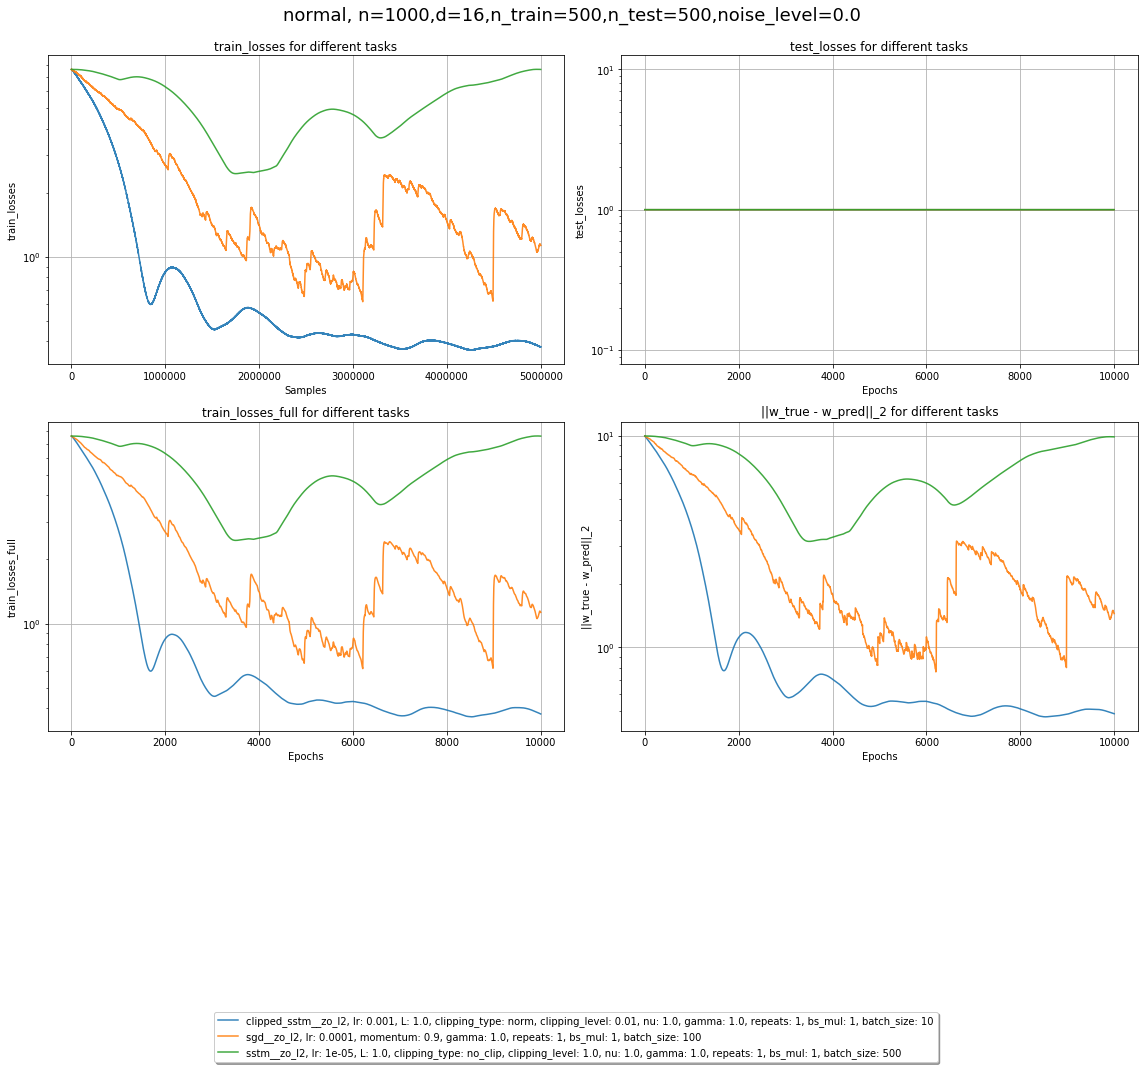

In [33]:
fig = plt.figure(figsize=(16,15))
gs = plt.GridSpec(6,4, figure=fig)

ax1 = fig.add_subplot(gs[0:2,0:2])

y_scale="log"

make_loss_plot(
    ax1, tasks_history_loaded_grouped, "train_losses", "train_losses", 
    x_label="Samples", 
    start_x=0, alpha=0.9, linestyle="-", eps=1.0, y_scale=y_scale, eps_auto=True,
)

ax2 = fig.add_subplot(gs[0:2,2:4])

make_loss_plot(
    ax2, tasks_history_loaded_grouped, "test_losses", "test_losses", 
    x_label="Epochs", 
    start_x=0, alpha=0.9, linestyle="-", eps=1.0, y_scale=y_scale
)

ax3 = fig.add_subplot(gs[2:4,0:2])

make_loss_plot(
    ax3, tasks_history_loaded_grouped, "train_losses_full", "train_losses_full", 
    x_label="Epochs", 
    start_x=0, alpha=0.9, linestyle="-", eps=0.1, y_scale=y_scale
)

ax4 = fig.add_subplot(gs[2:4,2:4])

make_loss_plot(
    ax4, tasks_history_loaded_grouped, "pred_w_true_w_norm_diff", "||w_true - w_pred||_2", 
    x_label="Epochs", 
    start_x=0, alpha=0.9, linestyle="-", eps=1.0, legend=False, y_scale=y_scale
)            

handles, labels = ax4.get_legend_handles_labels()
fig.legend(
    handles, labels, 
    loc='lower center', bbox_to_anchor=(0.5, 0.02), 
#                 bbox_to_anchor=(0.5, -0.05),
    fancybox=True, 
    shadow=True
)

fig.suptitle(dataset_name, y=1.02, fontsize=18)

calc_norm_diffs = True
calc_norm_diffs = False

if calc_norm_diffs:
    draw_norm_hists_for_different_models(
        fig, gs[4:,:], tasks_history_loaded_grouped, 
        bins_n=100, draw_normal=True)

fig.tight_layout()

plt.show()